### Python Script to Compute Mann Kendall trends written by Herbert. O. Misiani and modified by Samuel Ekwacu

### Computing persistent hot spell events trends over Africa-Seasonal

In [1]:
## libraries to install for first time 
#conda install -c conda-forge regionmask
# conda install -c conda-forge geopandas
#conda install -c conda-forge descartes
#conda install -c conda-forge pymannkendall
#conda install -c conda-forge cartopy
#conda install -c conda-forge pyogrio
#conda install -c conda-forge xeofs
#conda install -c conda-forge r-correlation
#conda install -c conda-forge pytest-regressions

In [22]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask

In [30]:
#uploaded.keys()
home_dir = 'D:/Folder_2023/Research/' ## read in the data
data_dir = 'Africa_Research/Hotspell_Africa/tmean_analysis/'
plot_dir = 'Africa_Research/Hotspell_Africa/trend_plots/tmean_plots/'
temp = xr.open_dataset(home_dir + data_dir + 'JRA55-tmean-monthly_v3_1961-2021.nc')  ##input file                          
#temp

In [31]:
###########NOTE; Change appropriately below to compute either annual or Seasonal trends #########

###For Annual Trends Only
Data=temp['tmean'].groupby('time.year').mean('time')    ## Group data into yearly means for annual trends
#Data

### For Seasonal trends of MAM, JJA, SON and DJF only
#Data_seas = temp.groupby('time.season')   ##Group data into seasonal means for seasonal trends
#Data_seas
#Data_sea = Data_seas['DJF']
#Data_sea
#Data = Data_sea['tmean'].groupby('time.year').mean('time') ## Group data into yearly means from seasonal mean.
#Data

In [32]:
#dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))  ## Slice to EA
dat_samp = Data.sel(Lon=slice(-20, 55), Lat=slice(-35, 40))  ## Slice to Africa
slope_val = np.zeros((len(dat_samp.Lat.values),len(dat_samp.Lon.values)))
p_value = np.zeros((len(dat_samp.Lat.values),len(dat_samp.Lon.values)))
#output = []
for i in np.arange(len(dat_samp.Lat.values)):
    for j in np.arange(len(dat_samp.Lon.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [33]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('Lat', 'Lon'), coords={'Lat':dat_samp.Lat, 'Lon':dat_samp.Lon}, attrs=dict(description="slope.", units="hsp year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('Lat', 'Lon'), coords={'Lat':dat_samp.Lat, 'Lon':dat_samp.Lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")
#data1
## Save Data as netcdf
#data1.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_trend.nc', mode='w')
#data2.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_pvalue.nc', mode='w')

In [34]:
## read the Shapefile of the Area of interest for use in masking over the required region
#sf = gpd.read_file('F://Folder_2022//Research//EA_Shp//East_Africa-Disolved.shp')  ## Used in Masking
#sf2 = shp.Reader('F://Folder_2022//Research//EA_Shp//EA.shp')       ## Used in plotting

sf = gpd.read_file('D://Folder_2023//Research//Africa_Research//shapefile//Africa_admin1.shp')  ## Used in Masking
sf2 = shp.Reader('D://Folder_2023//Research//Africa_Research//shapefile//Africa.shp')       ## Used in plotting

## Mask the trends and p_values
trend_mask = regionmask.mask_3D_geopandas(sf, data1.Lon, data1.Lat, lon_name='Lon', lat_name='Lat')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.Lon, data2.Lat, lon_name='Lon', lat_name='Lat')
trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)

C:\Users\Samuel-NUIST\AppData\Local\Temp\ipykernel_16472\1343087618.py:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


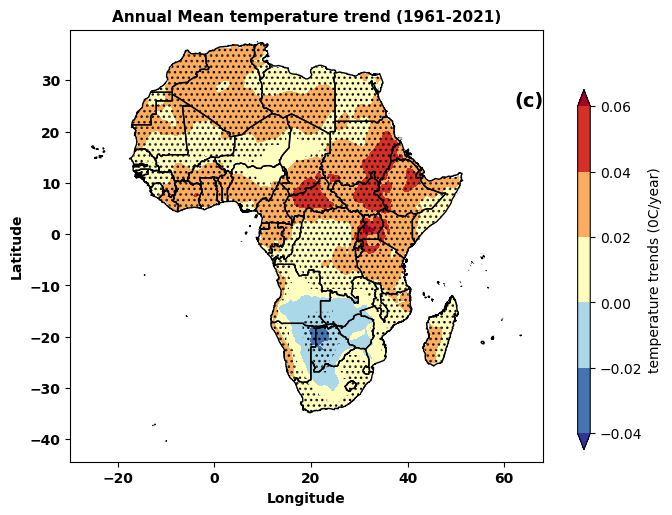

In [36]:

from matplotlib.colors import ListedColormap
none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True, figsize=(7, 6))

## Change this to the threshold you need.
#cond = (pval >= -0.05) & (pval <= 0.05)
cond = (pval <= 0.05)
## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))
    
cs = plt.contourf(dat_samp.Lon, dat_samp.Lat, trnd.values[:,:,0],  
               levels=np.arange(-0.04, 0.07, 0.02), cmap=plt.cm.RdYlBu_r, extend='both') #RdBu #YlOrRd,YlOrBr,YlOrBr  #levels=np.arange(-9, 12, 3)
## make a hatch of significance
hatch = ax.pcolor(dat_samp.Lon, dat_samp.Lat, sig_reg.data[:,:,0], cmap=none_map, 
                 hatch='...', edgecolor='black', lw=0, zorder=4)
## title attributes
plt.title('Annual Mean temperature trend (1961-2021)',fontsize=11, fontweight='bold')
plt.xticks(size = 10, fontweight='bold')
plt.yticks(size = 10, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=10, fontweight='bold')
plt.xlabel('Longitude',fontsize=10, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='temperature trends (0C/year)')
plt.text(-5, 30, '(c)',fontsize = 14, color ='black', fontweight='bold')
# save output
#plt.savefig(home_dir + plot_dir + 'Africa_tmean_JRA55-Annual1_1991-2021.png')
plt.savefig('C:/ERSSTv5/output/Africa_tmean_JRA55-Annual1_1961-2021.png', dpi=300)
plt.show()

### God is Greate















